<a href="https://colab.research.google.com/github/ImranSobuj/Speech-Emotion-Classification-SEC-from-RAVDESS-dataset/blob/main/Imran_Hossen_Data_Scientist_Speech_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Scientist - Speech Analysis
Take-Home Exercise 
Solved by 
Imran Hossen
imranhossenice15@gmail.com
https://www.linkedin.com/in/imranhsobuj97/

# Install Libraries

In [43]:
!pip3 install -r "/content/requirements.txt"

  Using cached https://files.pythonhosted.org/packages/ab/42/b4f04721c5c5bfc196ce156b3c768998ef8c0ae3654ed29ea5020c749a6b/PyAudio-0.2.11.tar.gz
  ERROR: Failed building wheel for pyaudio
  Running setup.py clean for pyaudio
Failed to build pyaudio
    Running setup.py install for pyaudio ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-6uah2ees/pyaudio/setup.py'"'"'; __file__='"'"'/tmp/pip-install-6uah2ees/pyaudio/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-hf2er6z2/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


librosa==0.8.0
optuna==2.7.0
numpy==1.19.5
pandas
soundfile==0.9.0
wave
sklearn
tqdm==4.28.1
matplotlib==2.2.3
pyaudio==0.2.11

# Import necessary library

In [44]:
import pandas as pd
import numpy as np
import os
import random
import sys
import glob 
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
import optuna
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [45]:
from google.colab import drive #Authenticate your google drive if you want to load data from drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# We are trying to build the following Data Frame from RAVDESS dataset

 data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                               'intensity', 'statement', 'repetition', 'emotion'])
                                

#### Data Frame

In [46]:
def make_data_frame():
    """
    Loads Data from directory containing WAV files.
    Make  Pandas Data frame to understand what's telling the file name 
    Filename example: 02-01-06-01-02-01-12.mp4
    Index->Means
    0: Video-only (02)
    1: Speech (01)
    2:Fearful (06)
    3: Normal intensity (01)
    4: Statement “dogs” (02)
    5: 1st Repetition (01)
    6: 12th Actor (12)
    7: Female, as the actor ID number is even.

    """
  
    data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])

    count = 0
    for file in tqdm(glob.glob("/content/drive/MyDrive/Freelance/Audio Actor Emotion classifiacation/Audio_Speech_Actors_01-24/Actor_*/*.wav")):
        file_name=os.path.basename(file)
        nm = file_name.split('.')[0].split('-')
        path = file_name
        src = int(nm[1]) 
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1
    return data_df



In [47]:
data_df = make_data_frame() 


100%|██████████| 1440/1440 [00:07<00:00, 186.24it/s]

In [48]:
data_df.head(100) #print first 100 rows

,path,source,actor,gender,intensity,statement,repetition,emotion
0,03-01-01-01-01-01-22.wav,1,22,female,0,0,0,1
1,03-01-01-01-01-02-22.wav,1,22,female,0,0,1,1
2,03-01-01-01-02-01-22.wav,1,22,female,0,1,0,1
3,03-01-02-01-02-01-22.wav,1,22,female,0,1,0,2
4,03-01-02-02-01-02-22.wav,1,22,female,1,0,1,2
...,...,...,...,...,...,...,...,...
95,03-01-05-02-02-02-23.wav,1,23,male,1,1,1,5
96,03-01-05-01-02-02-23.wav,1,23,male,0,1,1,5
97,03-01-06-01-01-02-23.wav,1,23,male,0,0,1,6
98,03-01-05-02-01-01-23.wav,1,23,male,1,0,0,5


In [49]:
data_df["source"][200:300] #Audio file

200    1
201    1
202    1
203    1
204    1
      ..
295    1
296    1
297    1
298    1
299    1
Name: source, Length: 100, dtype: object

# Class Label

In [50]:
def make_class_label(data_df):
  label_list = []
  for i in range(len(data_df)):
      if data_df.emotion[i] == 1: #neutral
        label = "neutral"
      elif data_df.emotion[i] == 2: # Calm
        label = "neutral"
      elif data_df.emotion[i] == 3: # Happy
        label = "positive"
      elif data_df.emotion[i] == 4: # Sad
        label = "negative"
      elif data_df.emotion[i] == 5: # Angry
        label = "negative"
      elif data_df.emotion[i] == 6: # Fearful
        label = "negative"
      elif data_df.emotion[i] == 7: # disgust
        label = "negative"
      else:                         # Surprised
        if data_df.intensity[i] ==1:
            label = "positive" # 1: normal>positive
        else: 
            label = "negative"  # 2: strong->negative
                 
        
       
      label_list.append(label)
    
  data_df['label'] = label_list 
  return data_df

In [51]:
data = make_class_label(data_df)


In [52]:
data.head(10)

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,03-01-01-01-01-01-22.wav,1,22,female,0,0,0,1,neutral
1,03-01-01-01-01-02-22.wav,1,22,female,0,0,1,1,neutral
2,03-01-01-01-02-01-22.wav,1,22,female,0,1,0,1,neutral
3,03-01-02-01-02-01-22.wav,1,22,female,0,1,0,2,neutral
4,03-01-02-02-01-02-22.wav,1,22,female,1,0,1,2,neutral
5,03-01-03-01-01-02-22.wav,1,22,female,0,0,1,3,positive
6,03-01-02-01-01-02-22.wav,1,22,female,0,0,1,2,neutral
7,03-01-03-01-02-01-22.wav,1,22,female,0,1,0,3,positive
8,03-01-03-01-02-02-22.wav,1,22,female,0,1,1,3,positive
9,03-01-02-02-01-01-22.wav,1,22,female,1,0,0,2,neutral


In [53]:

def make_class_label(data_df):
  label_list2 = []
  for i in range(len(data_df)):
      if data_df.emotion[i] == 1: #neutral
        label = "_neutral"
      if data_df.emotion[i] == 2: # Calm
       label = "_neutral"
      elif data_df.emotion[i] == 3: # Happy
        label = "_positive"
      elif data_df.emotion[i] == 4: # Sad
        label = "_negative"
      elif data_df.emotion[i] == 5: # Angry
        label = "_negative"
      elif data_df.emotion[i] == 6: # Fearful
        label = "_negative"
      elif data_df.emotion[i] == 7: # disgust
        label = "_negative"
      else:                         # Surprised
        if data_df.intensity[i] ==1:
            label = "_positive" # Intensity = 1: normal->positive
        else: 
            label = "_negative"  # Intensity = 2: strong->negative
                 
        
      # Add gender to the label    
      label_list2.append(data_df.gender[i] + label)
    
  data_df['label2'] = label_list2 
  return data_df


In [54]:
data = make_class_label(data_df)
data.tail(10)

,path,source,actor,gender,intensity,statement,repetition,emotion,label,label2
1430,03-01-06-02-02-02-03.wav,1,3,male,1,1,1,6,negative,male_negative
1431,03-01-06-02-01-02-03.wav,1,3,male,1,0,1,6,negative,male_negative
1432,03-01-07-02-02-02-03.wav,1,3,male,1,1,1,7,negative,male_negative
1433,03-01-08-01-01-01-03.wav,1,3,male,0,0,0,8,negative,male_negative
1434,03-01-08-02-01-02-03.wav,1,3,male,1,0,1,8,positive,male_positive
1435,03-01-08-02-02-01-03.wav,1,3,male,1,1,0,8,positive,male_positive
1436,03-01-08-01-02-01-03.wav,1,3,male,0,1,0,8,negative,male_negative
1437,03-01-08-02-02-02-03.wav,1,3,male,1,1,1,8,positive,male_positive
1438,03-01-08-01-02-02-03.wav,1,3,male,0,1,1,8,negative,male_negative
1439,03-01-08-02-01-01-03.wav,1,3,male,1,0,0,8,positive,male_positive


# Feature Extraciton

In [55]:
def extract_feature(file_name):
    """Function Extracts Features from WAV file
   - **MFCC** - Mel Frequency Cepstral Coefficients: 
Voice is dependent on the shape of vocal tract including tongue, teeth, etc.
Representation of short-time power spectrum of sound, essentially a representation of the vocal tract

- **STFT** - returns complex-valued matrix D of short-time Fourier Transform Coefficients:
Using abs(D[f,t]) returns magnitude of frequency bin f at frame t (Used as an input for Chroma_STFT)

- **Chroma_STFT** - (12 pitch classes) using an energy (magnitude) spectrum (obtained by taking the absolute value of the matrix returned by libROSA’s STFT function) instead of power spectrum returns normalized energy for each chroma bin at each frame

- **Mel Spectrogram** - magnitude spectrogram computed then mapped onto mel scale—x-axis is time, y-axis is frequency

    """
    X, sample_rate = librosa.load(file_name)
    stft=np.abs(librosa.stft(X))
    result=np.array([])
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    result=np.hstack((result, mfccs))
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))
    mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))
    return result

###  Load and Label the Dataset

In [56]:
def load_data(data):
    """Loads Data from directory containing WAV files."""
    x,y=[],[]
    for file in tqdm(glob.glob("/content/drive/MyDrive/Freelance/Audio Actor Emotion classifiacation/Audio_Speech_Actors_01-24/Actor_*/*.wav")):
        file_name=os.path.basename(file)
        feature=extract_feature(file) #Extract feauture
        x.append(feature)
    y =data.label #label of the datasets
    

    X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, train_size = 0.8, random_state=42) # Split Data into training set and testing set
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = load_data(data)


100%|██████████| 1440/1440 [06:21<00:00,  4.04it/s]


In [57]:
print(len(X_train), len(X_test)) # Train and Test data shape


1152 288


In [58]:
print(f'Features extracted: {len(X_train[-1])}')

Features extracted: 180


# Scale Data

In [59]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Model Parameters

In [60]:
rf_params = {'criterion': 'entropy', 
             'max_depth': 15, 
             'n_estimators': 22984, 
             'min_samples_leaf': 3, 
             'min_samples_split': 9, 
             'max_leaf_nodes': 239, 
             'random_state': 22}

In [61]:
mlp_params = {'activation': 'relu', 
              'solver': 'lbfgs', 
              'hidden_layer_sizes': 1283, 
              'alpha': 0.3849485717707319, 
              'batch_size': 163, 
              'learning_rate': 'constant',
              'max_iter':1000}

In [62]:
knn_params = {'weights': 'distance', 
              'n_neighbors': 32}

In [63]:
lr_params = {'multi_class':'multinomial',
             'class_weight': None, 
             'solver': 'saga', 
             'max_iter':10000}

# Model  Dictionaries

In [64]:
models = {
          'rf':RandomForestClassifier(**rf_params), 
          'mlp':MLPClassifier(**mlp_params), 
          'kn':KNeighborsClassifier(**knn_params),  
          'lr':LogisticRegression(**lr_params)}

model_abrv = { 
              'rf':'Random Forest Classifier', 
              'mlp':'MLP Classifier',
              'kn':'K-Nearest Neighbors', 
              'lr':'Logistic Regression', 
              }

# Modeling and Prediction

##Confusion matrix

In [65]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, model='clf', save=True):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a seaborn heatmap. 
    Saves confusion matrix file to jpg file."""
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    if save == True:
        plt.savefig('tuned_' + model_abrv[model] + '_confusion_matrix.jpg')
    plt.show()

## Model

In [66]:
def model(clf, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, models=models, save=False, print_stat=True, inc_train=False, cv=False):
    """Trains models and outputs score metrics. Takes an identifier, list of models, and split dataset as inputs and has options for saving model, 
    printing confusion matrix and classification report and getting cross-validated 5 fold accuracy."""
    clf_model = models[clf]
    clf_model.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
    if print_stat == True:
        clf_report = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).T
        clf_report.to_csv('tuned_' + model_abrv[clf] + '_classification_report.csv')
        print(model_abrv[clf])
        print('\nTest Stats\n', classification_report(y_test,y_pred))
        print_confusion_matrix(confusion_matrix(y_test, y_pred), unique_labels(y_test, y_pred), model=clf)
        if inc_train == True:
            print(model_abrv[clf])
            print('\nTrain Stats\n', classification_report(y_train,clf_model.predict(X_train)))
            print_confusion_matrix(confusion_matrix(y_train, clf_model.predict(X_train)), unique_labels(y_test, y_pred), model=clf)
    if cv == True:
        print(model_abrv[clf] + ' CV Accuracy:',  
              np.mean(cross_val_score(clf_model, X_train, y_train, cv=5, scoring='accuracy')))
    if save == True:
        return clf_model

## Modeling

### CV 5 Fold Accuracy

Random Forest Classifier

Test Stats
               precision    recall  f1-score   support

    negative       0.77      0.90      0.83       182
     neutral       0.75      0.74      0.74        65
    positive       0.69      0.22      0.33        41

    accuracy                           0.76       288
   macro avg       0.74      0.62      0.64       288
weighted avg       0.76      0.76      0.74       288



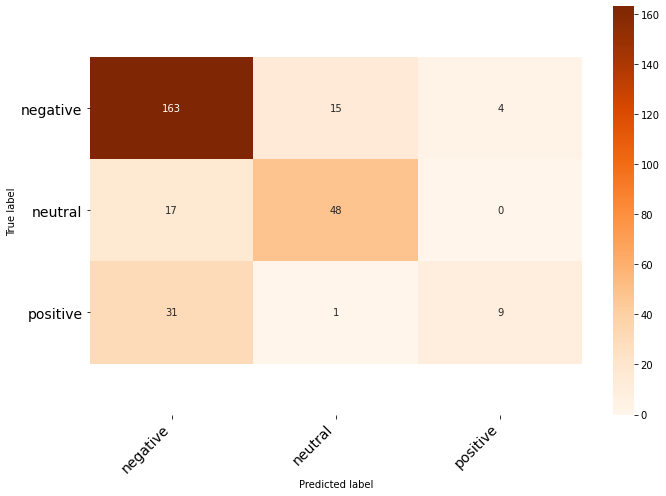

Random Forest Classifier CV Accuracy: 0.6952945605119518
MLP Classifier

Test Stats
               precision    recall  f1-score   support

    negative       0.84      0.82      0.83       182
     neutral       0.81      0.85      0.83        65
    positive       0.51      0.54      0.52        41

    accuracy                           0.78       288
   macro avg       0.72      0.73      0.73       288
weighted avg       0.79      0.78      0.79       288



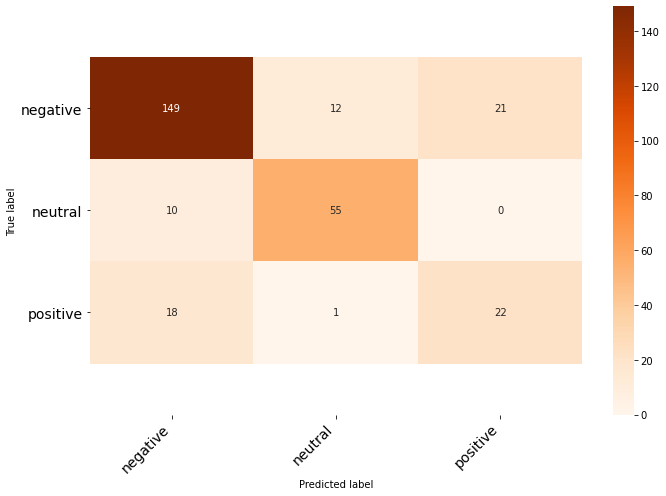

MLP Classifier CV Accuracy: 0.7499604743083005
K-Nearest Neighbors

Test Stats
               precision    recall  f1-score   support

    negative       0.73      0.92      0.81       182
     neutral       0.85      0.62      0.71        65
    positive       0.38      0.12      0.19        41

    accuracy                           0.74       288
   macro avg       0.66      0.55      0.57       288
weighted avg       0.71      0.74      0.70       288



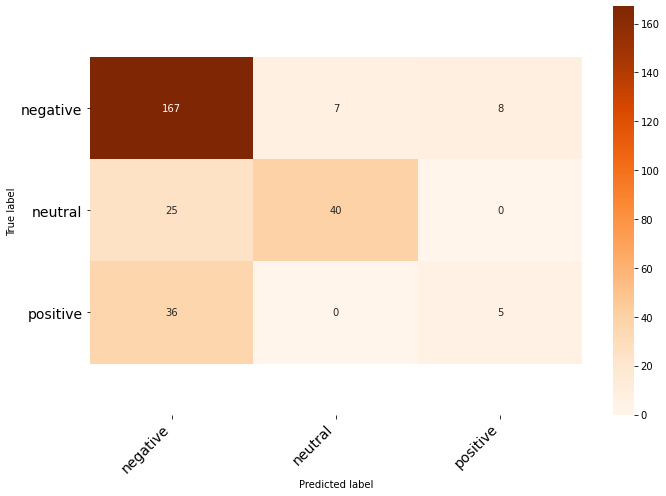

K-Nearest Neighbors CV Accuracy: 0.6501900997553172
Logistic Regression

Test Stats
               precision    recall  f1-score   support

    negative       0.75      0.75      0.75       182
     neutral       0.65      0.69      0.67        65
    positive       0.38      0.34      0.36        41

    accuracy                           0.68       288
   macro avg       0.59      0.59      0.59       288
weighted avg       0.67      0.68      0.67       288



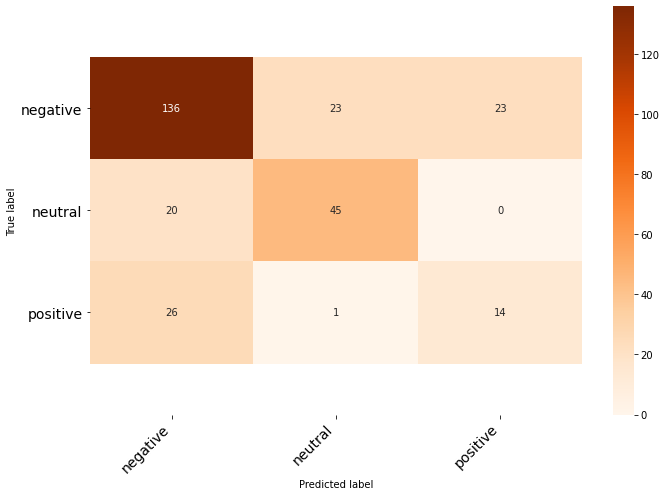

Logistic Regression CV Accuracy: 0.6475814041031434


In [67]:
for key in models.keys():
    model(key, cv= True, print_stat = True)  #set cv = True for cross-validation .Required much time

Random Forest Classifier

Test Stats
               precision    recall  f1-score   support

    negative       0.77      0.90      0.83       182
     neutral       0.75      0.74      0.74        65
    positive       0.69      0.22      0.33        41

    accuracy                           0.76       288
   macro avg       0.74      0.62      0.64       288
weighted avg       0.76      0.76      0.74       288



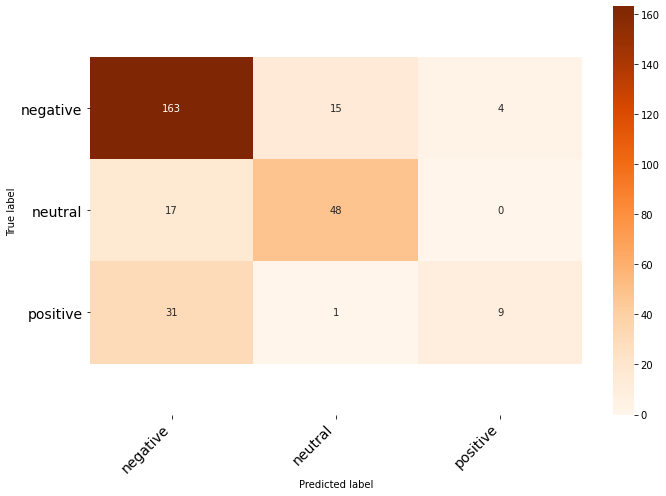

Random Forest Classifier

Train Stats
               precision    recall  f1-score   support

    negative       0.99      1.00      1.00       682
     neutral       1.00      1.00      1.00       223
    positive       1.00      0.98      0.99       247

    accuracy                           1.00      1152
   macro avg       1.00      0.99      0.99      1152
weighted avg       1.00      1.00      1.00      1152



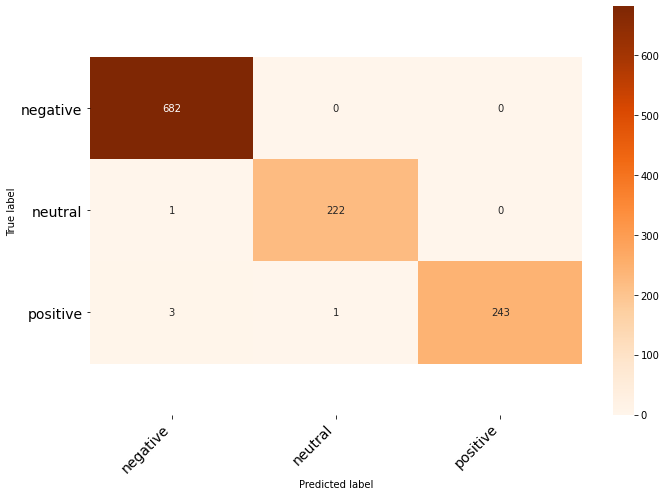

MLP Classifier

Test Stats
               precision    recall  f1-score   support

    negative       0.84      0.81      0.83       182
     neutral       0.79      0.86      0.82        65
    positive       0.51      0.54      0.52        41

    accuracy                           0.78       288
   macro avg       0.72      0.74      0.72       288
weighted avg       0.78      0.78      0.78       288



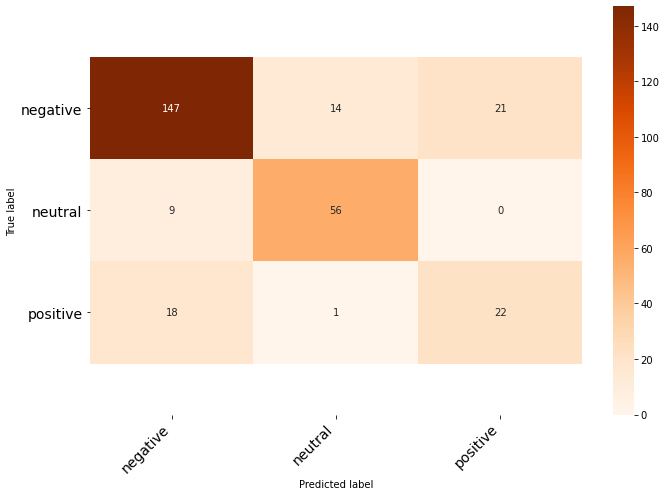

MLP Classifier

Train Stats
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00       682
     neutral       1.00      1.00      1.00       223
    positive       1.00      1.00      1.00       247

    accuracy                           1.00      1152
   macro avg       1.00      1.00      1.00      1152
weighted avg       1.00      1.00      1.00      1152



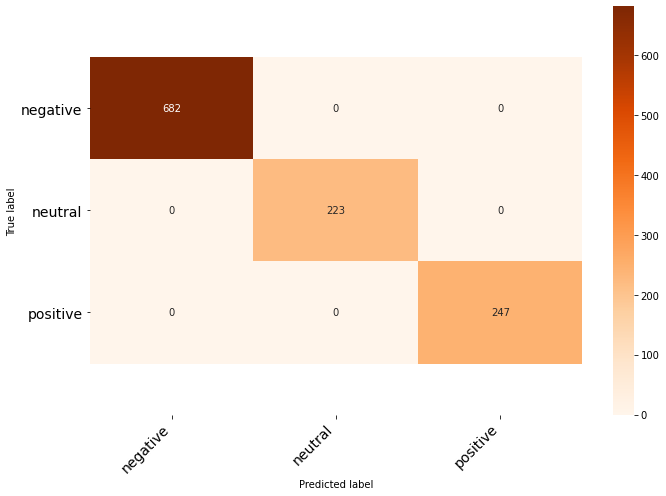

K-Nearest Neighbors

Test Stats
               precision    recall  f1-score   support

    negative       0.73      0.92      0.81       182
     neutral       0.85      0.62      0.71        65
    positive       0.38      0.12      0.19        41

    accuracy                           0.74       288
   macro avg       0.66      0.55      0.57       288
weighted avg       0.71      0.74      0.70       288



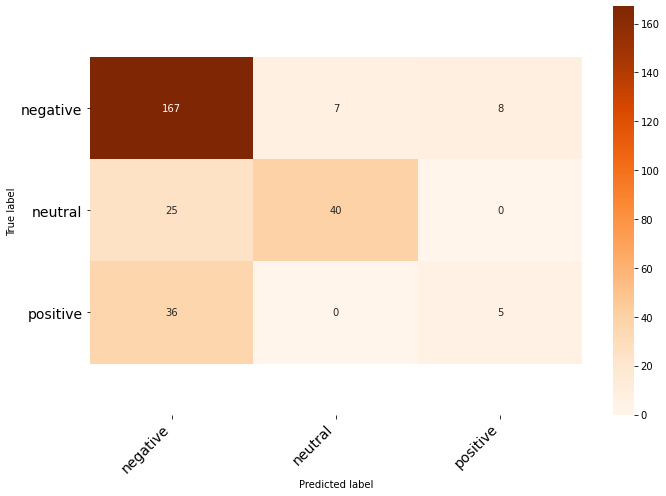

K-Nearest Neighbors

Train Stats
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00       682
     neutral       1.00      1.00      1.00       223
    positive       1.00      1.00      1.00       247

    accuracy                           1.00      1152
   macro avg       1.00      1.00      1.00      1152
weighted avg       1.00      1.00      1.00      1152



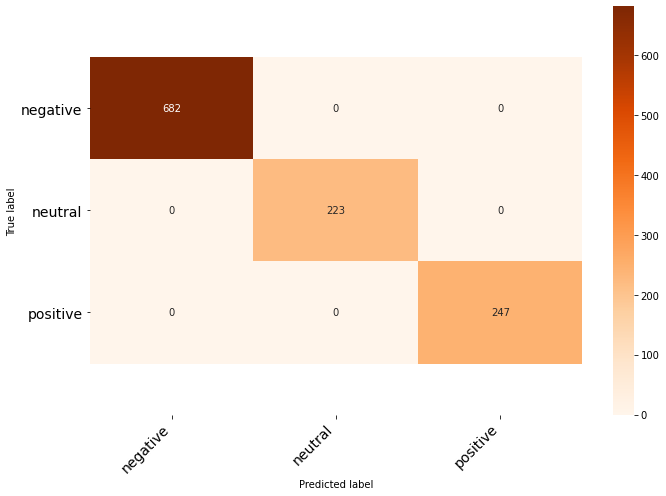

Logistic Regression

Test Stats
               precision    recall  f1-score   support

    negative       0.75      0.75      0.75       182
     neutral       0.65      0.69      0.67        65
    positive       0.38      0.34      0.36        41

    accuracy                           0.68       288
   macro avg       0.59      0.59      0.59       288
weighted avg       0.67      0.68      0.67       288



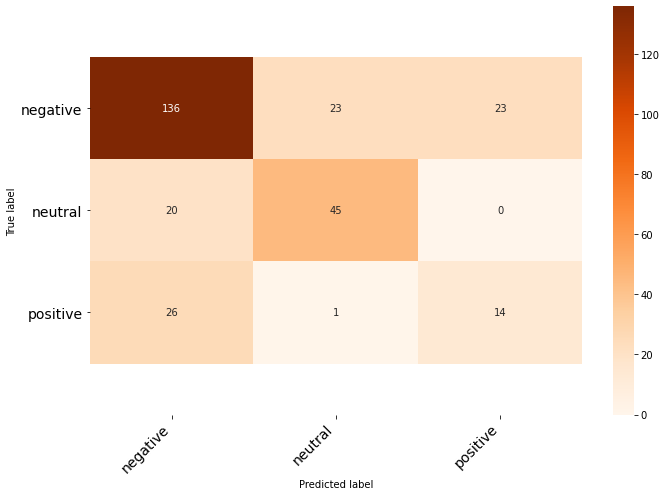

Logistic Regression

Train Stats
               precision    recall  f1-score   support

    negative       0.77      0.88      0.82       682
     neutral       0.73      0.71      0.72       223
    positive       0.77      0.51      0.61       247

    accuracy                           0.76      1152
   macro avg       0.76      0.70      0.72      1152
weighted avg       0.76      0.76      0.76      1152



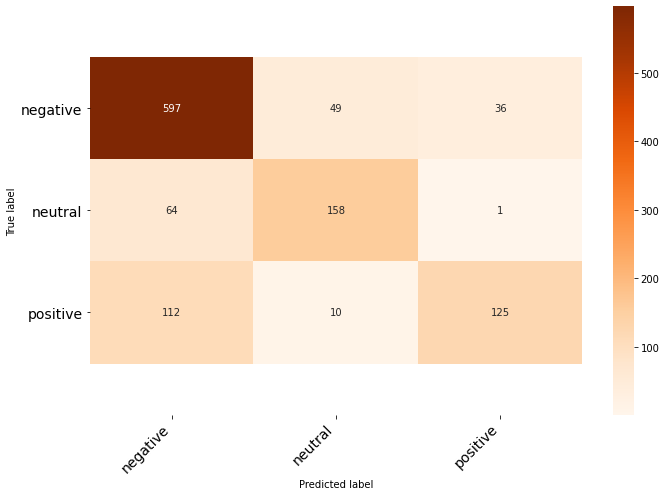

In [68]:
for key in models.keys():
    model(key, inc_train=True)

### Write Data to csv Files

In [69]:
for file, name in zip([X_train, X_test, y_train, y_test],['X_train.csv', 'X_test.csv', 'y_train.csv', 'y_test.csv']):
    pd.DataFrame(file).to_csv(name, index=False)

#Save and Test model

In [79]:
import pickle
from sklearn.externals import joblib
mlp_model = MLPClassifier()
mlp_model.fit(X_train, y_train)
# Save to file in the current working directory
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(mlp_model, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values

X_test = pd.read_csv("/content/X_test.csv")
y_test = pd.read_csv("/content/y_test.csv")
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(X_test)

Test score: 77.78 %


# Hyperparameter Tuning with Optuna

#### The hyperparameter tuning below will cause the notebook to run for a very long time

### Random Forest

In [71]:
def objective_rf(trial):
    
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 25),
        'n_estimators': trial.suggest_int('n_estimators', 15000, 25000),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 25),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 50, 250),
        }
   
    model = RandomForestClassifier(**params, random_state = 22) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [72]:
study = optuna.create_study(direction='maximize') #optimization  required much time
study.optimize(objective_rf, n_trials=5) 

[I 2021-05-31 01:56:30,161] A new study created in memory with name: no-name-5195f249-3458-46ac-8b4f-be0ee2f1945c
[I 2021-05-31 02:10:45,813] Trial 0 finished with value: 0.6935667231319406 and parameters: {'criterion': 'gini', 'max_depth': 23, 'n_estimators': 22800, 'min_samples_leaf': 2, 'min_samples_split': 9, 'max_leaf_nodes': 81}. Best is trial 0 with value: 0.6935667231319406.
[I 2021-05-31 02:21:10,584] Trial 1 finished with value: 0.6848898927159797 and parameters: {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 18776, 'min_samples_leaf': 4, 'min_samples_split': 11, 'max_leaf_nodes': 104}. Best is trial 0 with value: 0.6935667231319406.
[I 2021-05-31 02:40:14,528] Trial 2 finished with value: 0.6796725014116319 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 16639, 'min_samples_leaf': 3, 'min_samples_split': 25, 'max_leaf_nodes': 121}. Best is trial 0 with value: 0.6935667231319406.
[I 2021-05-31 03:05:38,971] Trial 3 finished with value: 0.68227

### MLP 

In [73]:
def objective_mlp(trial):

    params = {
        'activation': trial.suggest_categorical('activation', ['logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
        'hidden_layer_sizes':trial.suggest_int('hidden_layer_sizes', 100, 1500),
        'alpha': trial.suggest_uniform('alpha', 0.001, 0.99),
        'batch_size':trial.suggest_int('batch_size', 150, 300), 
        'learning_rate': trial.suggest_categorical('learning_rate', ['adaptive', 'constant', 'invscaling']),
        'max_iter': 1000
        }
  
    model = MLPClassifier(**params, random_state = 22) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [74]:
study = optuna.create_study(direction='maximize') #optimizattion required huge time
study.optimize(objective_mlp, n_trials=15)

[I 2021-05-31 03:32:58,510] A new study created in memory with name: no-name-f09167f7-f72d-43ce-83ba-e12273817ff4
[I 2021-05-31 03:33:04,812] Trial 0 finished with value: 0.5920120459250895 and parameters: {'activation': 'logistic', 'solver': 'sgd', 'hidden_layer_sizes': 1086, 'alpha': 0.6836823742171941, 'batch_size': 257, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 0.5920120459250895.
[I 2021-05-31 03:38:28,484] Trial 1 finished with value: 0.6814116318464145 and parameters: {'activation': 'tanh', 'solver': 'sgd', 'hidden_layer_sizes': 574, 'alpha': 0.5013384542862449, 'batch_size': 167, 'learning_rate': 'constant'}. Best is trial 1 with value: 0.6814116318464145.
[I 2021-05-31 03:42:20,404] Trial 2 finished with value: 0.6423640127987954 and parameters: {'activation': 'logistic', 'solver': 'sgd', 'hidden_layer_sizes': 498, 'alpha': 0.7839524182503973, 'batch_size': 233, 'learning_rate': 'constant'}. Best is trial 1 with value: 0.6814116318464145.
[I 2021-05-31 03:52:

### KNN

In [75]:
def objective_knn(trial):

    params = { 
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 200),
        }

    model = KNeighborsClassifier(**params) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [76]:
study = optuna.create_study(direction='maximize') #optimized rapidly
study.optimize(objective_knn, n_trials=10)

[I 2021-05-31 04:20:55,620] A new study created in memory with name: no-name-5dba6633-a015-45dd-80e3-70a52f9ebb9a
[I 2021-05-31 04:20:56,102] Trial 0 finished with value: 0.6432222849614154 and parameters: {'weights': 'distance', 'n_neighbors': 51}. Best is trial 0 with value: 0.6432222849614154.
[I 2021-05-31 04:20:56,636] Trial 1 finished with value: 0.5920120459250895 and parameters: {'weights': 'uniform', 'n_neighbors': 199}. Best is trial 0 with value: 0.6432222849614154.
[I 2021-05-31 04:20:57,111] Trial 2 finished with value: 0.6102277432712214 and parameters: {'weights': 'distance', 'n_neighbors': 81}. Best is trial 0 with value: 0.6432222849614154.
[I 2021-05-31 04:20:57,631] Trial 3 finished with value: 0.5937511763598721 and parameters: {'weights': 'uniform', 'n_neighbors': 162}. Best is trial 0 with value: 0.6432222849614154.
[I 2021-05-31 04:20:58,107] Trial 4 finished with value: 0.6102277432712214 and parameters: {'weights': 'distance', 'n_neighbors': 81}. Best is trial 

### Logistic Regression

In [77]:
def objective_lr(trial):

    params = { 
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga', 'lbfgs']),
        'multi_class':'multinomial',
        'max_iter': 5000
        }
    
    model = LogisticRegression(**params, random_state = 22) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [78]:
study = optuna.create_study(direction='maximize') #opimize rapidly
study.optimize(objective_lr, n_trials=10)

[I 2021-05-31 04:21:00,628] A new study created in memory with name: no-name-0c165cc6-c19c-4c39-9500-90df2305b23c
[I 2021-05-31 04:21:37,695] Trial 0 finished with value: 0.591142480707698 and parameters: {'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 0.591142480707698.
[I 2021-05-31 04:22:03,250] Trial 1 finished with value: 0.5885450781102955 and parameters: {'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 0 with value: 0.591142480707698.
[I 2021-05-31 04:22:49,506] Trial 2 finished with value: 0.6475814041031434 and parameters: {'class_weight': None, 'solver': 'saga'}. Best is trial 2 with value: 0.6475814041031434.
[I 2021-05-31 04:22:51,778] Trial 3 finished with value: 0.646711838885752 and parameters: {'class_weight': None, 'solver': 'newton-cg'}. Best is trial 2 with value: 0.6475814041031434.
[I 2021-05-31 04:22:54,010] Trial 4 finished with value: 0.646711838885752 and parameters: {'class_weight': None, 'solver': 'lbfgs'}. Best is tria